# Lecture 7: PyTorch

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.inspection import DecisionBoundaryDisplay

def plot_boundary(model, X, y):
    xrange = (-X[:, 0].min() + X[:, 0].max()) / 10
    yrange = (-X[:, y].min() + X[:, y].max()) / 10
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:, 0].min() - xrange, X[:, 0].max() + xrange, 250),
        np.linspace(X[:, 1].min() - yrange, X[:, 1].max() + yrange, 250)
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_pred = np.reshape(model.predict(torch.tensor(grid).float()).detach().numpy(), feature_1.shape)
    display = DecisionBoundaryDisplay(
        xx0=feature_1, xx1=feature_2, response=y_pred
    )
    display.plot()
    display.ax_.scatter(
        X[:, 0], X[:, 1], c=y, edgecolor="black"
    )
    plt.show()

## Introduction to PyTorch

The most basic object in PyTorch is a `tensor`. Tensor objects behave much like the `AutogradValue` objects we are creating in the homework! We can create a `tensor` object with a given value as follows

In [45]:
x = torch.tensor(4.)
x

tensor(4.)

Performing basic operations on `tensor` objects gives tensor objects.

In [46]:
a = x ** 2 + 5
a

tensor(21.)

`tensor` objects also support reverse-mode automatic differentiation! To use this, we must specify that we will want to compute the derivative with respect to a given `tensor`. We can do this with the `requires_grad` argument.

In [47]:
x = torch.tensor(4., requires_grad=True)

Once we have a `tensor` that `requires_grad`, we can perform operations on it to compute a loss.

In [48]:
a = x ** 2 + 5
L = torch.log(a) # Functions like log must be called through torch
L

tensor(3.0445, grad_fn=<LogBackward0>)

Once we have a loss running the backward pass is done exactly as in the homework. First we call `backward()` on the loss `tensor` object, then we can access the derivative through the `grad` property of `x`.

In [49]:
L.backward()
x.grad

tensor(0.3810)

We can also create `tensor` objects that wrap arrays.

In [50]:
x = torch.tensor(np.array([3, 4, 5]))
x

tensor([3, 4, 5])

We can also just directly create tensors as we would numpy arrays

In [51]:
x = torch.tensor([3, 4, 5])
x

tensor([3, 4, 5])

Including convienience constructors.

In [52]:
print(torch.ones((5,)))
print(torch.zeros((2, 3)))

tensor([1., 1., 1., 1., 1.])
tensor([[0., 0., 0.],
        [0., 0., 0.]])


Automatic differentiation still works for arrays. In this case it gives use the gradient of the loss (hence the `grad` property).

In [53]:
x = torch.tensor([3., 4., 5.], requires_grad=True)
L = torch.sum(x ** 2)
L

tensor(50., grad_fn=<SumBackward0>)

In [54]:
L.grad

/var/folders/t9/fjsr8h1x7c7cg4vqw_xhjq2w0000gn/T/ipykernel_79454/323164392.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:491.)
  L.grad


In [55]:
L.backward()
x.grad

tensor([ 6.,  8., 10.])

We can convert `tensor` objects back to numpy by calling `x.detach().numpy()`. (`detach` removes the variable from any automatic differentiation computations)

In [56]:
x.detach().numpy()

array([3., 4., 5.], dtype=float32)

At this point it's probably worth remarking on where the name `tensor` comes from. 

So far we've discussed 3 kinds of array objects
- **Scalars:** which are just single values (0-dimensional)
- **Vectors:** 1-dimensional arrays of numbers
- **Matrices:** 2-dimensional arrays of numbers

![Alt text](image.png)

A **tensor** is the generalization of a vector or matrix to *any* number of dimensions. For example, a 3-dimensional tensor can be seen in multiple ways.

![Alt text](image-1.png)

A `tensor` object can be created with any number of dimensions. For example, we could create a 2x2x2 tensor as:

In [57]:
t = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
t

tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])

Or we could create the tensor in the image using `arange` and `reshape`.

In [58]:
t = torch.arange(30).reshape((3, 2, 5))
t

tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9]],

        [[10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]],

        [[20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29]]])

4-dimensional tensors can also be visualized

![Alt text](image-2.png)

In [59]:
t = torch.ones((3, 2, 4, 5))
t.shape

torch.Size([3, 2, 4, 5])

There are some notable differences between torch and numpy when it comes to operations. The important one to watch out for at this point is matrix multiplation. In numpy we accomplished with with `np.dot`:

In [60]:
x = np.ones((4, 5))
w = np.ones((5, 2))
np.dot(x, w)

array([[5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.]])

In PyTorch `torch.dot` only does vector dot products and thus only applies to 1-dimensional `tensor` objects:

In [61]:
x = torch.ones((4, 5))
w = torch.ones((5, 2))
torch.dot(x, w)

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

Instead we use the `torch.matmul` function for this purpose

In [62]:
torch.matmul(x, w)

tensor([[5., 5.],
        [5., 5.],
        [5., 5.],
        [5., 5.]])

PyTorch also has many handy built-in functions that numpy doesn't have, such as `sigmoid`.

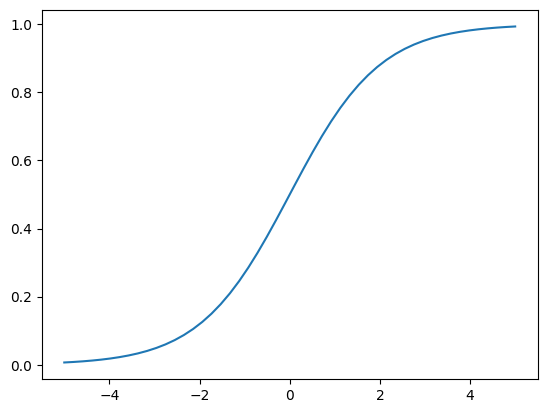

In [63]:
x = torch.linspace(-5, 5, 50)
s = torch.sigmoid(x)
plt.plot(x, s)

This makes it very easy to implement something like logistic regression. 

In [64]:
class LogisticRegression:
    def __init__(self, dims):
        self.weights = torch.ones((dims,), requires_grad=True)
        self.bias = torch.zeros((), requires_grad=True)

    def predict_probability(self, X):
        f_X = torch.matmul(X, self.weights) + self.bias
        return torch.sigmoid(f_X)

    def predict(self, X):
        return self.predict_probability(X) > 0.5


Let's try loading a dataset, converting it to `tensor` and making predictions

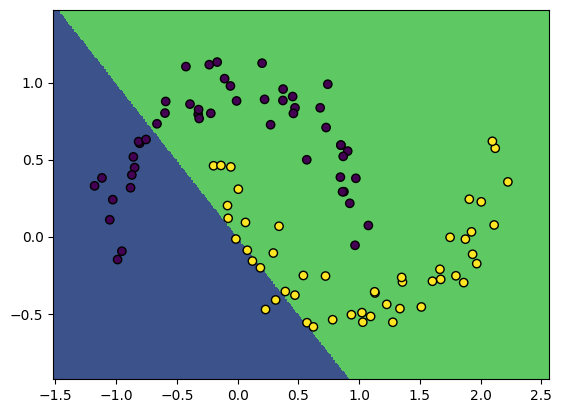

In [65]:
X, y = make_moons(noise=0.1)
X, y = torch.tensor(X).float(), torch.tensor(y)

model = LogisticRegression(2)
plot_boundary(model, X, y)

When working with PyTorch, it is convention to separate the loss function from the model, where the loss function will just take predictions and labels.

In [66]:
def NLL(pred, y):
    LL = y * torch.log(pred) + (1. - y) * torch.log(1. - pred)
    return -LL.sum()

## Gradient descent

Gradient descent is also implemented in PyTorch in the `optim` module.

In [67]:
from torch import optim

Gradient descent works a bit differently in PyTorch than what we've seen. We first need to construct a gradient descent *object* which specifies which values we're optimizing and what the learning rate will be. We specify the values to optimize by simply passing a list of weights/parameters to the constructor.

In PyTorch, basic gradient descent is encapsulated in the `optim.SGD` class (`SGD` stands for *stochastic gradient descent*, we'll talk about what *stochastic* means in this context next week.)

In [68]:
optimizer = optim.SGD([model.weights, model.bias], lr=0.1)

Notice that this object doesn't even take in the function we're trying to optimize, only the inputs. We need to call the function ourselves *and* run `backward()` to compute the gradients. 

In [69]:
predictions = model.predict_probability(X)
loss = NLL(predictions, y)
loss.backward()


Let's look at our model `weights`

In [70]:
model.weights
model.weights.grad

tensor([-5.6526, 24.1355])

We can take a single step of gradient descent using the `step` method of the optimizer.

In [71]:
optimizer.step()
model.weights

tensor([ 1.5653, -1.4135], requires_grad=True)

We see that this actually updates the weights themselves!

It's important to note that in PyTorch, calling `backward` does **not** clear the value stored in grad. So computing the gradient multiple times will result in updates to the gradient.

In [72]:
print(model.weights.grad)
NLL(model.predict_probability(X), y).backward()
print(model.weights.grad)
NLL(model.predict_probability(X), y).backward()
print(model.weights.grad)

tensor([-5.6526, 24.1355])
tensor([-14.5242,  28.7704])
tensor([-23.3958,  33.4053])


We can clear the stored gradients using the optimizer.

In [73]:
optimizer.zero_grad()
print(model.weights.grad)

None


So far we've only taking a single step of gradient descent. In order to run many steps, we need to write a loop to do everything we just saw.

In [74]:
for i in range(10):
    predictions = model.predict_probability(X)
    loss = NLL(predictions, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

45.934814453125
40.60100555419922
32.82542037963867
30.3773136138916
28.918834686279297
28.118915557861328
27.602989196777344
27.248106002807617
26.989551544189453
26.794662475585938


We should now see that our model has been optimized!

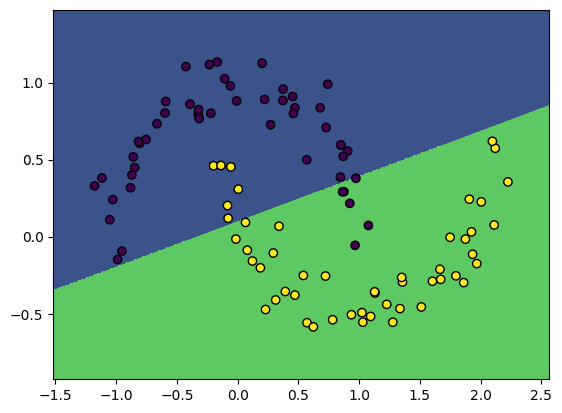

In [75]:
plot_boundary(model, X, y)

## torch.nn

While PyTorch as a tool for automatic differentiation and optimization would be useful by itself. It actually gives us a lot more than that!

On of the most important features of PyTorch is its model-building tools in the `torch.nn` module. This gives us a lot of powerful features that we can use to build complex neural networks!



In [76]:
from torch import nn

Let's start by building out logistic regression model in the `torch.nn` framwork. In order for a model to benefit from `torch.nn` our model class needs to inheret from `nn.Module`

In [77]:
class LogisticRegression(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.weights = nn.Parameter(torch.ones((dims,)))
        self.bias = nn.Parameter(torch.zeros(()))

    def forward(self, X):
        return torch.sigmoid(torch.matmul(X, self.weights) + self.bias)

    def predict_probability(self, X):
        return self.forward(X)

    def predict(self, X):
        return self.forward(X) > 0.5

There are 2 changes to note here. The first is that we wrapped our `weights` and `bias` terms in `nn.Parameter`. This tells PyTorch that these are the parameters we will want to optimize. We don't need to specify `requires_grad` for parameters, PyTorch will take care of that for us.

The second is that we moved the implmentation of `predict_probability` to `forward`. In PyTorch models the `forward` method is special, it defines the model as a function. If we call the model as a function `forward` will be called internally.

In [78]:
model = LogisticRegression(2)
model(X)

tensor([0.5652, 0.7431, 0.8238, 0.5468, 0.8991, 0.5719, 0.8651, 0.7784, 0.6153,
        0.7053, 0.7419, 0.3129, 0.4502, 0.5031, 0.4508, 0.7075, 0.7626, 0.4756,
        0.4158, 0.4693, 0.7904, 0.7241, 0.2430, 0.5297, 0.7944, 0.8496, 0.6825,
        0.6149, 0.6730, 0.5231, 0.6151, 0.6108, 0.5509, 0.7476, 0.6634, 0.8512,
        0.8117, 0.7527, 0.5092, 0.7742, 0.8012, 0.7604, 0.6411, 0.3242, 0.2805,
        0.4016, 0.6296, 0.3000, 0.7045, 0.7307, 0.7442, 0.8091, 0.5104, 0.8006,
        0.6166, 0.5173, 0.6404, 0.5779, 0.8199, 0.9030, 0.7872, 0.6059, 0.8091,
        0.9367, 0.5806, 0.7576, 0.8079, 0.3847, 0.4926, 0.4909, 0.8605, 0.6233,
        0.5605, 0.5980, 0.3629, 0.6874, 0.8761, 0.7593, 0.8267, 0.7912, 0.7147,
        0.4980, 0.4396, 0.9295, 0.8956, 0.5096, 0.7148, 0.7788, 0.7961, 0.2600,
        0.4964, 0.6008, 0.5710, 0.7882, 0.9379, 0.8573, 0.7131, 0.8105, 0.6835,
        0.5392], grad_fn=<SigmoidBackward0>)

This means that we can use instances of `nn.Module` as parameterized functions. For example, we might create a general linear (technically affine) function in the same way.

$$f(\mathbf{x}) = \mathbf{x}^T\mathbf{W}^T + \mathbf{b},  \quad f: \mathbb{R}^i \rightarrow \mathbb{R}^o$$

Note that here we are **not** assuming an augmented representation of $\mathbf{x}$.

In [79]:
class Linear(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.weightsT = nn.Parameter(torch.ones((inputs, outputs)))
        self.bias = nn.Parameter(torch.zeros((outputs,)))

    def forward(self, X):
        return torch.matmul(X, self.weightsT) + self.bias

We can use this module to implement out logistic regression model above.

In [80]:
class LogisticRegression(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.linear = Linear(dims, 1)                       # Dims input 1 output

    def forward(self, X):
        return torch.sigmoid(self.linear(X)).reshape((-1,)) # Turn output into a vector

    def predict_probability(self, X):
        return self.forward(X)

    def predict(self, X):
        return self.forward(X) > 0.5

In [81]:
model = LogisticRegression(2)
model(X)

tensor([0.5652, 0.7431, 0.8238, 0.5468, 0.8991, 0.5719, 0.8651, 0.7784, 0.6153,
        0.7053, 0.7419, 0.3129, 0.4502, 0.5031, 0.4508, 0.7075, 0.7626, 0.4756,
        0.4158, 0.4693, 0.7904, 0.7241, 0.2430, 0.5297, 0.7944, 0.8496, 0.6825,
        0.6149, 0.6730, 0.5231, 0.6151, 0.6108, 0.5509, 0.7476, 0.6634, 0.8512,
        0.8117, 0.7527, 0.5092, 0.7742, 0.8012, 0.7604, 0.6411, 0.3242, 0.2805,
        0.4016, 0.6296, 0.3000, 0.7045, 0.7307, 0.7442, 0.8091, 0.5104, 0.8006,
        0.6166, 0.5173, 0.6404, 0.5779, 0.8199, 0.9030, 0.7872, 0.6059, 0.8091,
        0.9367, 0.5806, 0.7576, 0.8079, 0.3847, 0.4926, 0.4909, 0.8605, 0.6233,
        0.5605, 0.5980, 0.3629, 0.6874, 0.8761, 0.7593, 0.8267, 0.7912, 0.7147,
        0.4980, 0.4396, 0.9295, 0.8956, 0.5096, 0.7148, 0.7788, 0.7961, 0.2600,
        0.4964, 0.6008, 0.5710, 0.7882, 0.9379, 0.8573, 0.7131, 0.8105, 0.6835,
        0.5392], grad_fn=<ReshapeAliasBackward0>)

The power here is that because `Linear` is also an instance of `nn.Module`, PyTorch knows that it's weights should also be considered part of our models weights. We can access the weights of a model using the `parameters()` method.

In [82]:
list(model.parameters())

[Parameter containing:
 tensor([[1.],
         [1.]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

This lets us easily apply gradient descent:

In [83]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

for i in range(10):
    predictions = model(X)        # Now we can just call model!
    loss = NLL(predictions, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

76.53839111328125
45.934814453125
40.60100555419922
32.82542037963867
30.3773136138916
28.918834686279297
28.118915557861328
27.602989196777344
27.248106002807617
26.989551544189453


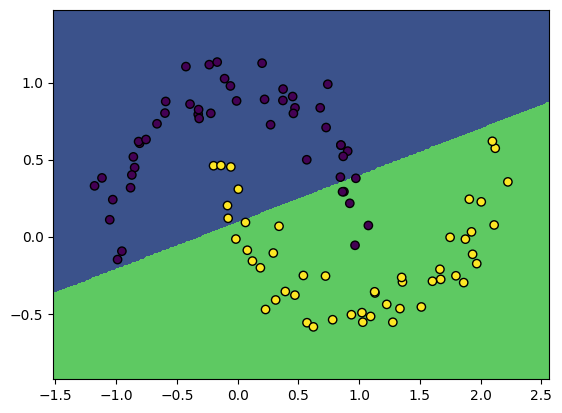

In [84]:
plot_boundary(model, X, y)

PyTorch unsurprisingly also provides a built-in `Linear` module. As `nn.Linear`.

In [85]:
nn.Linear(2, 1)

Linear(in_features=2, out_features=1, bias=True)

Knowing how to make a parameterized function in PyTorch, let's consider making a neural network layer with a sigmoid activation function.

$$f(\mathbf{x}) = \sigma(\mathbf{x}^T\mathbf{W}^T + \mathbf{b})$$

In [86]:
class SigmoidLayer(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.linear = nn.Linear(inputs, outputs)

    def forward(self, X):
        return torch.sigmoid(self.linear(X))
        

Let's create a layer with 10 neurons. (So $\mathbf{W}:\ (10 \times 2)$)

In [87]:
layer = SigmoidLayer(2, 10)
print(X.shape)
layer(X).shape

torch.Size([100, 2])


torch.Size([100, 10])

Let's use this to create a neural network class for binary classification!

In [88]:
class NeuralNetwork(nn.Module):
    def __init__(self, dims, hidden_size):
        super().__init__()
        self.layer = SigmoidLayer(dims, hidden_size)
        self.linear = Linear(hidden_size, 1)                       

    def forward(self, X):
        hidden_neurons = self.layer(X)
        output = self.linear(hidden_neurons)
        return torch.sigmoid(output).reshape((-1,))

    def predict_probability(self, X):
        return self.forward(X)

    def predict(self, X):
        return self.forward(X) > 0.5

We see that PyTorch recognizes both the parameters of the logistic regression and the parameters of our neural network feature transform:

In [89]:
model = NeuralNetwork(2, 10)
list(model.parameters())

[Parameter containing:
 tensor([[-0.0632, -0.0324],
         [-0.4227, -0.0076],
         [ 0.5793, -0.4920],
         [ 0.1640, -0.5442],
         [ 0.2326,  0.3651],
         [-0.0184,  0.6859],
         [ 0.0893,  0.1236],
         [-0.4774, -0.3702],
         [-0.0048,  0.4830],
         [-0.4720,  0.5458]], requires_grad=True),
 Parameter containing:
 tensor([-0.2695, -0.1038, -0.7001,  0.3398, -0.0591,  0.6680,  0.3601, -0.3093,
          0.0831, -0.4315], requires_grad=True),
 Parameter containing:
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

This means that we can easily run our optimization as before.

In [90]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

for i in range(100):
    predictions = model(X)        # Now we can just call model!
    loss = NLL(predictions, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

251.74571228027344
461.0118103027344
62.689453125
58.230892181396484
51.833839416503906
45.31672668457031
42.269630432128906
41.090309143066406
42.59092712402344
44.23348617553711
51.76810073852539
45.51247024536133
48.5499267578125
37.86709976196289
36.245426177978516
32.07354736328125
30.741405487060547
29.285472869873047
28.51435089111328
27.839073181152344
27.37657928466797
26.992008209228516
26.69622802734375
26.455289840698242
26.262691497802734
26.106895446777344
25.978981018066406
25.872283935546875
25.78037452697754
25.699132919311523
25.625377655029297
25.55675506591797
25.492244720458984
25.430410385131836
25.371490478515625
25.31437873840332
25.260303497314453
25.208097457885742
25.160297393798828
25.115331649780273
25.07819175720215
25.046260833740234
25.029979705810547
25.02396011352539
25.0517578125
25.099485397338867
25.22385025024414
25.381305694580078
25.71344757080078
26.064964294433594
26.785503387451172
27.31593894958496
28.478464126586914
28.659645080566406
29.682

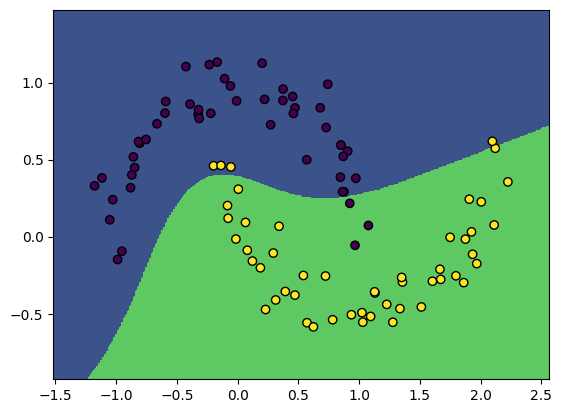

In [91]:
plot_boundary(model, X, y)

PyTorch also gives us an easier (but less flexible) way to define a composition of modules like this. In PyTorch we can define this simple network using `nn.Sequential`

In [92]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)
model(X).reshape((-1,))

tensor([0.3653, 0.3638, 0.3685, 0.3575, 0.3788, 0.3567, 0.3749, 0.3824, 0.3716,
        0.3777, 0.3612, 0.3494, 0.3608, 0.3496, 0.3610, 0.3802, 0.3737, 0.3504,
        0.3581, 0.3621, 0.3859, 0.3814, 0.3410, 0.3605, 0.3768, 0.3890, 0.3599,
        0.3586, 0.3567, 0.3529, 0.3723, 0.3711, 0.3682, 0.3644, 0.3774, 0.3742,
        0.3804, 0.3808, 0.3526, 0.3757, 0.3669, 0.3735, 0.3731, 0.3516, 0.3461,
        0.3566, 0.3558, 0.3496, 0.3594, 0.3775, 0.3755, 0.3808, 0.3586, 0.3792,
        0.3543, 0.3657, 0.3559, 0.3642, 0.3848, 0.3816, 0.3824, 0.3546, 0.3808,
        0.3906, 0.3661, 0.3723, 0.3823, 0.3552, 0.3561, 0.3543, 0.3730, 0.3723,
        0.3523, 0.3669, 0.3531, 0.3590, 0.3764, 0.3702, 0.3680, 0.3841, 0.3798,
        0.3555, 0.3480, 0.3861, 0.3814, 0.3495, 0.3793, 0.3814, 0.3839, 0.3427,
        0.3540, 0.3623, 0.3700, 0.3661, 0.3915, 0.3718, 0.3660, 0.3685, 0.3601,
        0.3597], grad_fn=<ReshapeAliasBackward0>)

Here `nn.Sigmoid` is a built-in module that just applies the sigmoid function. Its implementation would look like:

In [93]:
class SigmoidLayer(nn.Module):
    def forward(self, X):
        return torch.sigmoid(X)

We could use this to create a network with several hidden layers:

In [94]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)
model(X)

tensor([[0.4041],
        [0.4038],
        [0.4038],
        [0.4040],
        [0.4038],
        [0.4039],
        [0.4038],
        [0.4041],
        [0.4042],
        [0.4041],
        [0.4038],
        [0.4042],
        [0.4042],
        [0.4039],
        [0.4042],
        [0.4042],
        [0.4040],
        [0.4039],
        [0.4042],
        [0.4042],
        [0.4042],
        [0.4042],
        [0.4041],
        [0.4041],
        [0.4040],
        [0.4041],
        [0.4039],
        [0.4039],
        [0.4038],
        [0.4039],
        [0.4042],
        [0.4042],
        [0.4042],
        [0.4039],
        [0.4042],
        [0.4038],
        [0.4040],
        [0.4041],
        [0.4039],
        [0.4040],
        [0.4038],
        [0.4040],
        [0.4042],
        [0.4042],
        [0.4041],
        [0.4042],
        [0.4039],
        [0.4042],
        [0.4038],
        [0.4041],
        [0.4040],
        [0.4040],
        [0.4041],
        [0.4040],
        [0.4038],
        [0

PyTorch also provides built-in loss functions. The PyTorch function for the negative log-likelihood for logistic regression is called `nn.functional.binary_cross_entropy`. It has some sharp edges though. 

For one, it expects `y` to be a float type. We can convert a PyTorch `int` tensor into a `float` one by calling the `float` method.

We also see that our sequential model returns a column vector, so `y` should match that as well.

In [95]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

yfloat = y.float().reshape((-1, 1))

for i in range(100):
    predictions = model(X)        # Now we can just call model!
    loss = nn.functional.binary_cross_entropy(predictions, yfloat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

0.712141752243042
0.7091044783592224
0.7065528631210327
0.7044107913970947
0.7026132941246033
0.7011056542396545
0.6998415589332581
0.6987819671630859
0.6978939771652222
0.6971497535705566
0.696526288986206
0.6960040330886841
0.6955663561820984
0.6951996684074402
0.694892406463623
0.6946350336074829
0.6944191455841064
0.6942383646965027
0.6940867900848389
0.6939594745635986
0.6938527822494507
0.6937631964683533
0.6936879754066467
0.69362473487854
0.6935714483261108
0.6935266852378845
0.6934890151023865
0.6934571266174316
0.6934301853179932
0.6934073567390442
0.693388044834137
0.693371593952179
0.693357527256012
0.6933454871177673
0.6933351755142212
0.6933264136314392
0.6933186054229736
0.6933119297027588
0.693306028842926
0.6933008432388306
0.6932962536811829
0.6932921409606934
0.6932885050773621
0.6932851672172546
0.6932820081710815
0.6932792067527771
0.6932765245437622
0.6932740807533264
0.693271815776825
0.6932694911956787
0.6932673454284668
0.6932653784751892
0.6932634115219116
0.6

For convinience, let's definie a wrapper class for our model.

In [96]:
class LogisticRegressionNeuralNetwork(nn.Module):
    def __init__(self, network):
        super().__init__()
        self.network = network                   

    def forward(self, X):
        return self.network(X).reshape((-1,))

    def predict_probability(self, X):
        return self.forward(X)

    def predict(self, X):
        return self.forward(X) > 0.5

## Evaluating models

We see that we have a *lot* of options when designing a neural network. So far the choices we've seen are:
- The number of layers
- The number of neurons in each layer
- The activation function
- The learning rate for gradient descent

And this is just the beginning! As we go on, we'll learn about many more options that we have.

Let's take a look at how to make some of these choices. In many real cases, our data will not be a cleanly separated into 2 classes as we've seen. For instance, we can look at a noisier version of the dataset we saw before.

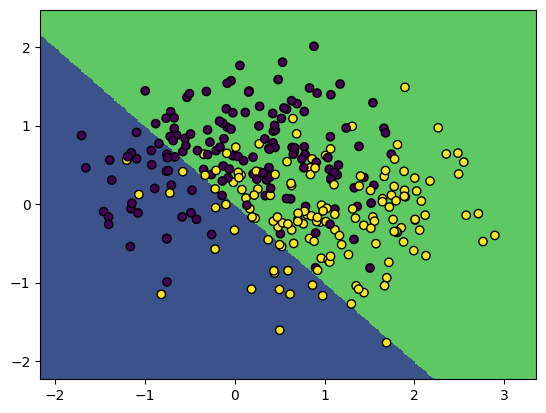

In [97]:
X, y = make_moons(300, noise=0.5)
X, y = torch.tensor(X).float(), torch.tensor(y)


model = LogisticRegression(2)
plot_boundary(model, X, y)

Let's split this into training and test sets as we've seen.

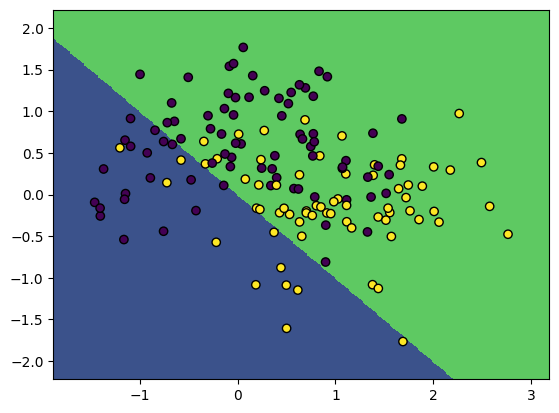

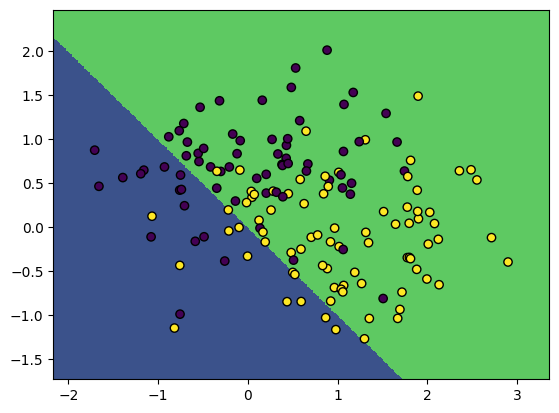

In [98]:
inds = np.arange(X.shape[0])
np.random.shuffle(inds)
Xtrain, ytrain = X[inds[:150]], y[inds[:150]]
Xtest, ytest = X[inds[150:]], y[inds[150:]]
plot_boundary(model, Xtrain, ytrain)
plot_boundary(model, Xtest, ytest)

We'll start by fitting a logistic regression model as we've seen.

In [99]:
network = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid(),
)
model = LogisticRegressionNeuralNetwork(network)   

optimizer = optim.SGD(model.parameters(), lr=0.1)

for i in range(500):
    predictions = model(Xtrain)        # Now we can just call model!
    loss = NLL(predictions, ytrain.flatten())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

127.65480041503906
147.39797973632812
99.01510620117188
113.0787582397461
106.0920639038086
161.87832641601562
114.1411361694336
145.89279174804688
98.93666076660156
117.2277603149414
101.8545913696289
140.513427734375
109.4571533203125
145.58836364746094
102.63407897949219
126.65000915527344
102.01583099365234
135.04779052734375
106.65965270996094
142.10926818847656
104.1931381225586
132.24771118164062
102.77326202392578
133.9228973388672
105.18921661376953
139.1488494873047
104.62230682373047
134.86273193359375
103.43161010742188
134.19154357910156
104.5163345336914
137.31463623046875
104.61583709716797
135.83790588378906
103.86148834228516
134.7530059814453
104.25921630859375
136.35430908203125
104.49825286865234
136.070556640625
104.0972900390625
135.22093200683594
104.19034576416016
135.92173767089844
104.38951873779297
136.03619384765625
104.20794677734375
135.51808166503906
104.19206237792969
135.7626190185547
104.31770324707031
135.943603515625
104.25088500976562
135.6765594482

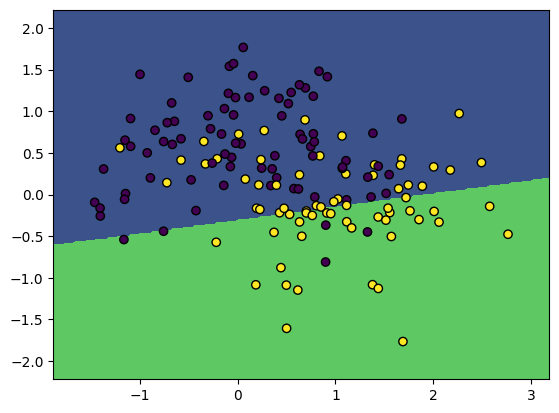

In [100]:
plot_boundary(model, Xtrain, ytrain)

Let's compute the accuracy on both the training and the test data

In [101]:
train_acc = (model.predict(Xtrain) == ytrain).float().mean()
test_acc = (model.predict(Xtest) == ytest).float().mean()
print('Training accuracy: %.3f, Test accuracy: %.3f' % (train_acc, test_acc))

Training accuracy: 0.713, Test accuracy: 0.680


In [115]:
network = nn.Sequential(
    nn.Linear(2, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1),
    nn.Sigmoid(),
)
model = LogisticRegressionNeuralNetwork(network)   

optimizer = optim.SGD(model.parameters(), lr=0.00001)

import tqdm
pbar = tqdm.trange(50000)
for i in pbar:
    predictions = model(Xtrain)        # Now we can just call model!
    loss = NLL(predictions, ytrain.flatten())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description('Loss: %.3f' % loss.item())
    #print(loss.item())

Loss: nan:   9%|▊         | 4322/50000 [00:20<03:41, 206.03it/s]   


KeyboardInterrupt: 

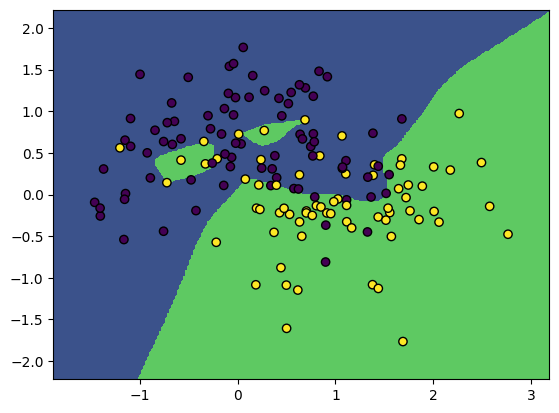

In [111]:
plot_boundary(model, Xtrain, ytrain)